In [ ]:
!pip install datasets rouge_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 9.7 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=f18e2b1f30a44de3cccafb97d03a9ee01f99cb62d7

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import gensim.downloader as api
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, GRU, Bidirectional, Conv1D, MaxPooling1D, TimeDistributed, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from datasets import load_dataset
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [ ]:
# Parameters
max_len_input = 100
max_len_target = 50
latent_dim = 256
embedding_dim = 300  # As per Word2Vec dimensions
dataset_name = "allenai/multinews_dense_oracle"
batch_size = 64
epochs = 10


In [ ]:
# Load datasets
dataset = load_dataset(dataset_name)
dataset_train = dataset['train'].select(range(2000))  # Using smaller data for example
dataset_val = dataset['validation'].select(range(1000))
dataset_test = dataset['test'].select(range(1000))

Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

In [ ]:
print(dataset_train.shape)

(2000, 2)


In [ ]:
# Prepare data
def prepare_data(dataset):
    input_texts = [str(data['document']) for data in dataset]
    target_texts = ["\t " + str(data['summary']) + " \n" for data in dataset]
    return input_texts, target_texts

In [ ]:
train_input_texts, train_target_texts = prepare_data(dataset_train)
val_input_texts, val_target_texts = prepare_data(dataset_val)
test_input_texts, test_target_texts = prepare_data(dataset_test)

In [ ]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_input_texts + train_target_texts + val_input_texts + val_target_texts)
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
print(vocab_size)

124027


In [ ]:
word2vec = api.load("word2vec-google-news-300")

[=====================================-------------] 75.9% 1261.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 77.6% 1290.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 79.3% 1319.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================================----------] 81.3% 1351.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 83.0% 1379.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================================--------] 84.7% 1408.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================------] 88.7% 1474.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================================-----] 90.4% 1502.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 92.1% 1531.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
#creation of embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [ ]:
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass


In [ ]:
embedding_matrix.shape

(124027, 300)

In [ ]:
embedding_vector.shape

(300,)

In [ ]:
# Helper function to convert and pad sequences
def process_texts(input_texts, target_texts):
    input_sequences = tokenizer.texts_to_sequences(input_texts)
    target_sequences = tokenizer.texts_to_sequences(target_texts)
    input_sequences = pad_sequences(input_sequences, maxlen=max_len_input, padding='post')
    target_sequences = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
    return input_sequences, target_sequences


In [ ]:
input_sequences, target_sequences = process_texts(train_input_texts, train_target_texts)
val_input_sequences, val_target_sequences = process_texts(val_input_texts, val_target_texts)
test_input_sequences, test_target_sequences = process_texts(test_input_texts, test_target_texts)


In [ ]:
# Decoder input and target data
decoder_input_data = target_sequences[:, :-1]
decoder_target_data = target_sequences[:, 1:]
decoder_target_data_one_hot = to_categorical(decoder_target_data, num_classes=vocab_size)

val_decoder_input_data = val_target_sequences[:, :-1]
val_decoder_target_data = val_target_sequences[:, 1:]
val_decoder_target_data_one_hot = to_categorical(val_decoder_target_data, num_classes=vocab_size)

test_decoder_input_data = test_target_sequences[:, :-1]
test_decoder_target_data = test_target_sequences[:, 1:]
test_decoder_target_data_one_hot = to_categorical(test_decoder_target_data, num_classes=vocab_size)


In [ ]:
# Define the model

# Encoder
encoder_inputs = Input(shape=(max_len_input,))
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(encoder_inputs)
encoder_conv = Conv1D(filters=latent_dim, kernel_size=3, activation='relu', padding='same')(encoder_embedding)
encoder_pool = MaxPooling1D(pool_size=2)(encoder_conv)
encoder_gru = GRU(latent_dim, return_state=True)
encoder_outputs, state_h = encoder_gru(encoder_pool)
encoder_states = [state_h]

In [ ]:

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding_layer = Embedding(input_dim=vocab_size, output_dim=latent_dim)
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_bigru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=False))
decoder_outputs = decoder_bigru(decoder_embedding, initial_state=encoder_states + encoder_states)  # Adjust initial_state
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Checkpoint callback
checkpoint_path = "/content/drive/MyDrive/Model_data/model_checkpoint_cnn.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [ ]:
# Training the model
history = model.fit(
    [input_sequences, decoder_input_data],
    decoder_target_data_one_hot,  # one-hot encoded labels
    batch_size=batch_size,
    epochs=50,
    validation_data=([val_input_sequences, val_decoder_input_data], val_decoder_target_data_one_hot),  # corrected validation data
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 9.6435 - accuracy: 0.0599
Epoch 1: val_loss improved from inf to 8.09835, saving model to /content/drive/MyDrive/Model_data/model_checkpoint_cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 148s 4s/step - loss: 9.6435 - accuracy: 0.0599 - val_loss: 8.0984 - val_accuracy: 0.0579
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 7.6061 - accuracy: 0.0597
Epoch 2: val_loss improved from 8.09835 to 7.86685, saving model to /content/drive/MyDrive/Model_data/model_checkpoint_cnn.h5
32/32 [==============================] - 103s 3s/step - loss: 7.6061 - accuracy: 0.0597 - val_loss: 7.8668 - val_accuracy: 0.0585
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 7.4451 - accuracy: 0.0601
Epoch 3: val_loss improved from 7.86685 to 7.84911, saving model to /content/drive/MyDrive/Model_data/model_checkpoint_cnn.h5
32/32 [==============================] - 103s 3s/step - loss: 7.4451 - accuracy: 0.0601 - val_loss: 7.8491 - val_accuracy: 0.0585
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 7.3969 - accuracy: 0.0603
Epoch 4: val_loss did not improve from 7.84911
32/32 [======================

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('model_checkpoint_cnn.h5')

In [ ]:
!pip install rouge

In [ ]:
import nltk
nltk.download('punkt')
from rouge import Rouge
import pandas as pd
import numpy as np
import nltk
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('model_checkpoint_cnn.h5')

def evaluate_average_scores(model, input_data, decoder_input_data, target_data, tokenizer):
    # Generate predictions
    pred_one_hot = model.predict([input_data, decoder_input_data])
    pred_labels = np.argmax(pred_one_hot, axis=-1)

    # Convert predictions and true labels to texts
    true_texts = [' '.join(tokenizer.sequences_to_texts([seq])) for seq in target_data.argmax(axis=-1)]
    pred_texts = [' '.join(tokenizer.sequences_to_texts([seq])) for seq in pred_labels]

    # Calculate ROUGE scores
    rouge_scores = calculate_rouge_scores(true_texts, pred_texts)

    # Calculate BLEU score
    bleu_score = calculate_bleu_score(true_texts, pred_texts)

    return rouge_scores, bleu_score

def calculate_rouge_scores(true_texts, pred_texts):
    # Initialize the ROUGE scorer
    rouge = Rouge()

    # Calculate ROUGE scores
    scores = rouge.get_scores(pred_texts, true_texts, avg=True)

    return scores

def calculate_bleu_score(true_texts, pred_texts):
    # Tokenize true and predicted texts
    true_tokens = [nltk.word_tokenize(text.lower()) for text in true_texts]
    pred_tokens = [nltk.word_tokenize(text.lower()) for text in pred_texts]

    # Calculate BLEU score
    bleu_score = corpus_bleu([[true_sent] for true_sent in true_tokens], pred_tokens)

    return bleu_score

# Example usage
rouge_scores, bleu_score = evaluate_average_scores(loaded_model, test_input_sequences, test_decoder_input_data, test_decoder_target_data_one_hot, tokenizer)
print("Average ROUGE Scores:")
print(rouge_scores)
print("BLEU Score:", bleu_score)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


32/32 [==============================] - 8s 214ms/step
Average ROUGE Scores:
{'rouge-1': {'r': 0.6524688617504875, 'p': 0.6502364558963898, 'f': 0.6512093101889641}, 'rouge-2': {'r': 0.48154296320383533, 'p': 0.4807046221676442, 'f': 0.4811078459445354}, 'rouge-l': {'r': 0.6520033234191095, 'p': 0.6497787051813361, 'f': 0.6507477587150358}}
BLEU Score: 0.40991465146581874


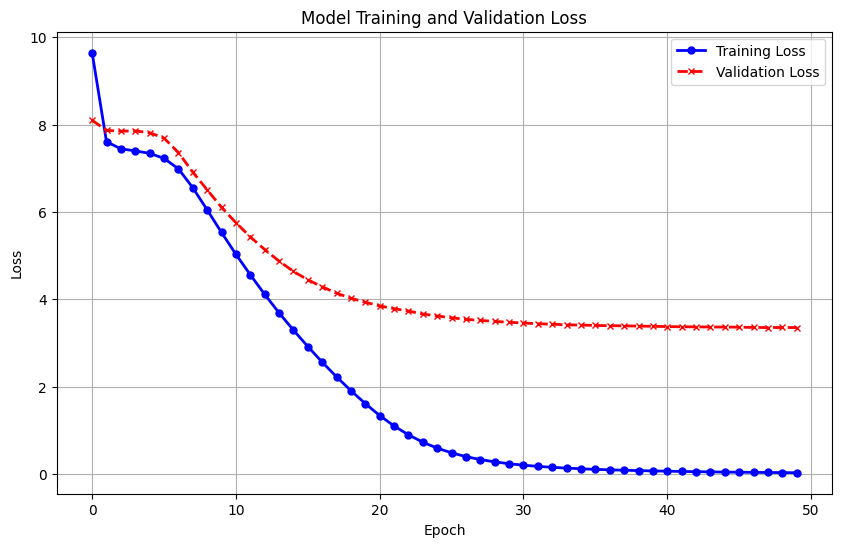

In [ ]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Plot training & validation loss with specific line style and marker
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-', marker='o', linewidth=2, markersize=5)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', marker='x', linewidth=2, markersize=5)

# Add title and axis labels
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add grid
plt.grid(True)

# Add legend to specify which line is which
plt.legend()

# Show the plot
plt.show()

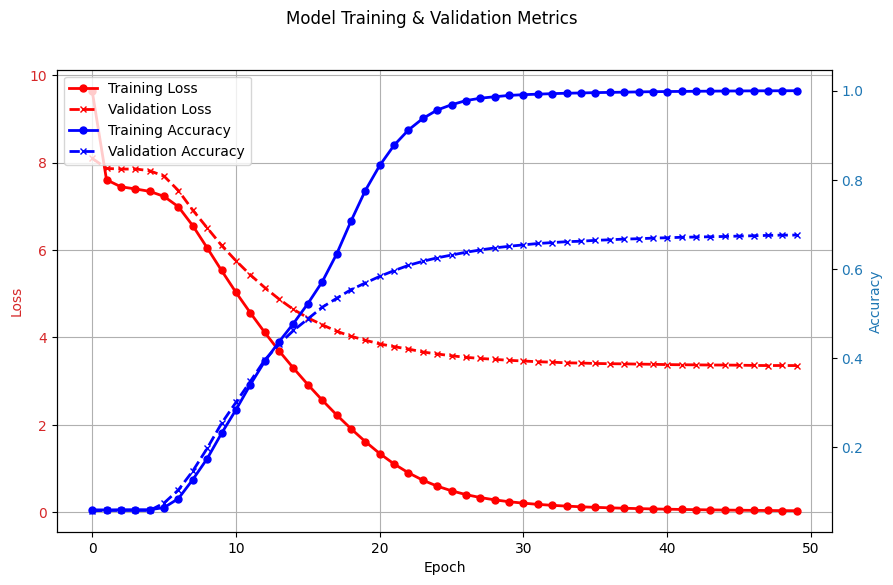

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training and validation loss
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
loss_train_line, = ax1.plot(history.history['loss'], label='Training Loss', color='red', linestyle='-', marker='o', linewidth=2, markersize=5)
loss_val_line, = ax1.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', marker='x', linewidth=2, markersize=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Instantiate a second y-axis for same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
accuracy_train_line, = ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='-', marker='o', linewidth=2, markersize=5)
accuracy_val_line, = ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='--', marker='x', linewidth=2, markersize=5)
ax2.tick_params(axis='y', labelcolor=color)

# Create a legend for all lines
lines = [loss_train_line, loss_val_line, accuracy_train_line, accuracy_val_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Add a title to the figure
fig.suptitle('Model Training & Validation Metrics')

# Show the plot
plt.show()


In [ ]:
# Load the best model
# model.load_weights('model_checkpoint.h5')


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from rouge import Rouge
import pandas as pd

def evaluate_average_rouge(model, input_data, decoder_input_data, target_data, tokenizer):
    # Generate predictions
    pred_one_hot = model.predict([input_data, decoder_input_data])
    pred_labels = np.argmax(pred_one_hot, axis=-1)

    # Convert predictions and true labels to texts
    true_texts = [' '.join(tokenizer.sequences_to_texts([seq])) for seq in target_data.argmax(axis=-1)]
    pred_texts = [' '.join(tokenizer.sequences_to_texts([seq])) for seq in pred_labels]

    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    all_scores = [scorer.score(true, pred) for true, pred in zip(true_texts, pred_texts)]

    # Calculate average scores
    average_scores = {key: {'precision': 0, 'recall': 0, 'fmeasure': 0} for key in ['rouge1', 'rouge2', 'rougeL']}
    for score in all_scores:
        for key in score:
            average_scores[key]['precision'] += score[key].precision
            average_scores[key]['recall'] += score[key].recall
            average_scores[key]['fmeasure'] += score[key].fmeasure

    # Average the summed scores
    num_scores = len(all_scores)
    for key in average_scores:
        average_scores[key]['precision'] /= num_scores
        average_scores[key]['recall'] /= num_scores
        average_scores[key]['fmeasure'] /= num_scores

    # Convert to DataFrame for display
    df = pd.DataFrame(average_scores).transpose()
    df.columns = ['Precision', 'Recall', 'F-measure']
    return df

# Example usage
average_rouge_scores = evaluate_average_rouge(model, test_input_sequences, test_decoder_input_data, test_decoder_target_data_one_hot, tokenizer)
print("Average ROUGE Scores:")
print(average_rouge_scores)


32/32 [==============================] - 7s 221ms/step
Average ROUGE Scores:
        Precision    Recall  F-measure
rouge1   0.689061  0.686047   0.687488
rouge2   0.486024  0.483910   0.484920
rougeL   0.686866  0.683866   0.685300


In [ ]:
import numpy as np
from rouge_score import rouge_scorer
import pandas as pd

def evaluate_rouge_scores(model, input_data, decoder_input_data, target_data, tokenizer):
    # Prediction
    pred_one_hot = model.predict([input_data, decoder_input_data])
    pred_labels = np.argmax(pred_one_hot, axis=-1)

    # Convert labels to text using the tokenizer
    true_texts = [' '.join(tokenizer.sequences_to_texts([seq])) for seq in target_data.argmax(axis=-1)]
    pred_texts = [' '.join(tokenizer.sequences_to_texts([seq])) for seq in pred_labels]

    # Initialize ROUGE scorer, including ROUGE-S
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], use_stemmer=True)
    scores = [scorer.score(t, p) for t, p in zip(true_texts, pred_texts)]

    # Prepare data for display
    results = []
    for score_dict in scores:
        row = {}
        for key, value in score_dict.items():
            row[f'{key}_precision'] = value.precision
            row[f'{key}_recall'] = value.recall
            row[f'{key}_fmeasure'] = value.fmeasure
        results.append(row)

    # Convert list of dicts to DataFrame for easy visualization
    results_df = pd.DataFrame(results)
    average_results = results_df.mean()

    return average_results

# Example usage
average_rouge_scores = evaluate_rouge_scores(model, test_input_sequences, test_decoder_input_data, test_decoder_target_data_one_hot, tokenizer)
print("Average ROUGE Scores:")
print(average_rouge_scores.to_string())


32/32 [==============================] - 7s 221ms/step
Average ROUGE Scores:
rouge1_precision       0.689061
rouge1_recall          0.686047
rouge1_fmeasure        0.687488
rouge2_precision       0.486024
rouge2_recall          0.483910
rouge2_fmeasure        0.484920
rougeL_precision       0.686866
rougeL_recall          0.683866
rougeL_fmeasure        0.685300
rougeLsum_precision    0.686866
rougeLsum_recall       0.683866
rougeLsum_fmeasure     0.685300


In [ ]:
def generate_summary(input_text, tokenizer, model, max_len_input, max_len_target):
    # Preprocess the input text (tokenization and padding)
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_len_input, padding='post')

    # Initialize the sequence for the output summary with the start token
    start_token, stop_token = '<start>', '<end>'
    start_token_idx = tokenizer.word_index.get(start_token, 1)  # Default to 1 if not found
    stop_token_idx = tokenizer.word_index.get(stop_token, 2)  # Default to 2 if not found

    # Start with the start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token_idx

    # Initialize summary with empty list
    summary = []

    for i in range(max_len_target):
        # Predict the next word
        output_tokens = model.predict([input_seq, target_seq])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tokenizer.index_word[sampled_token_index] if sampled_token_index > 0 else None

        # Check for stop condition: either hit stop token or max length
        if sampled_token == stop_token or sampled_token is None:
            break

        # Append the token as part of the summary
        summary.append(sampled_token)

        # Update the target sequence (of length 1) to be the token just generated
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return ' '.join(summary)

# Example usage:
new_document = "My Name is abhinay"
summary = generate_summary(new_document, tokenizer, model, max_len_input, max_len_target)
print("Generated Summary:")
print(summary)


1/1 [==============================] - 0s 34ms/step
Generated Summary:
rubble form regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations regulations


In [ ]:
import numpy as np

def generate_summary(input_text, tokenizer, model, max_len_input, max_len_target, temperature=1.0):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_len_input, padding='post')

    start_token_idx = tokenizer.word_index.get('<start>', 1)
    target_seq = np.array([[start_token_idx]])

    summary = []

    for i in range(max_len_target):
        predictions = model.predict([input_seq, target_seq])[0, -1, :]
        predictions = np.log(predictions) / temperature
        exp_predictions = np.exp(predictions)
        predictions = exp_predictions / np.sum(exp_predictions)
        sampled_token_index = np.random.choice(len(predictions), p=predictions)

        if sampled_token_index == tokenizer.word_index.get('<end>', 2):
            break

        sampled_token = tokenizer.index_word.get(sampled_token_index, None)
        summary.append(sampled_token)

        target_seq = np.array([[sampled_token_index]])

    return ' '.join(summary)

# Adjust 'temperature' as needed (values >1.0 increase diversity, <1.0 make outputs more deterministic)
summary = generate_summary(new_document, tokenizer, model, max_len_input, max_len_target, temperature=0.8)
print("Generated Summary:")
print(summary)


1/1 [==============================] - 0s 36ms/step
Generated Summary:
reality founded alyssa alyssa whisky pill regulations earlier here ” alyssa beads quartz innocent diseases alyssa alyssa projects lines prisons available him later alyssa alyssa alyssa ” alyssa punched her her diseases succeeds ” alyssa dead involvement camp satisfaction headaches projects turmoil regulations alyssa beads beads alyssa lines projects projects


In [ ]:
# Load text from 'testdoc.txt'
with open('testdoc.txt', 'r', encoding='utf-8') as file:
    testdoc_text = file.read()

# Preprocess the text
testdoc_sequence = tokenizer.texts_to_sequences([testdoc_text])
padded_testdoc_sequence = pad_sequences(testdoc_sequence, maxlen=max_len_input, padding='post')

# Generate a summary
test_decoder_input = np.zeros((1, 1))
summary = ""
for _ in range(max_len_target):
    output_tokens = model.predict([padded_testdoc_sequence, test_decoder_input])
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = tokenizer.index_word[sampled_token_index]
    summary += ' ' + sampled_char
    test_decoder_input = np.array([[sampled_token_index]])
    if sampled_char == '\n':
        break

print("Generated summary:", summary)

1/1 [==============================] - 0s 33ms/step
Generated summary:  regulations yesterday reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters reports reuters
